In [1]:
using Revise

In [22]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra
;

In [24]:
const λ = 626e-9
const Γ = 2π * 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
;

In [97]:
H_operator = :(
    T * L +
    B_z * (1.4e6 * Zeeman_L0)
)
parameters = @params begin
    T = 478e12
    B_z = 0.
end

# Create basis states
QN_bounds = (L = 0, N = 1)
ground_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)
QN_bounds = (L = 1, N = 1)
excited_states = enumerate_states(AngularMomentumState_Labelled, QN_bounds)

# Create Hamiltonian
basis = [ground_states; excited_states]
H = Hamiltonian(basis=basis, operator=H_operator, parameters=parameters)
H.parameters.B_z = 0.

evaluate!(H)
QuantumStates.solve!(H)

update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms

# d[1:5, 6:end, 1] ./= sqrt(sum(d[1:5, 6:end, 1].^2))
# d[6:end, 1:5, 1] ./= sqrt(sum(d[6:end, 1:5, 1].^2))
# d[1:5, 6:end, 2] ./= sqrt(sum(d[1:5, 6:end, 2].^2))
# d[6:end, 1:5, 2] ./= sqrt(sum(d[6:end, 1:5, 2].^2))
# d[1:5, 6:end, 3] ./= sqrt(sum(d[1:5, 6:end, 3].^2))
# d[6:end, 1:5, 3] ./= sqrt(sum(d[6:end, 1:5, 3].^2))
# d[1:5,1:5,:] .= 0.0
# d[6:8,6:8,:] .= 0.0
;

In [272]:
# Laser parameters
Δ = +1.0Γ
s = 3.0

# Frequency of the lasers (in angular frequency units)
ω = 2π * (energy(H.states[end]) - energy(H.states[1])) + Δ

ϵ_(ϵ1) = t -> ϵ1

k̂ = +x̂; ϵ1 = ϵ_(rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω, s)
k̂ = -x̂; ϵ2 = ϵ_(rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω, s)
k̂ = +ŷ; ϵ3 = ϵ_(rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω, s)
k̂ = -ŷ; ϵ4 = ϵ_(rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω, s)
k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω, s)
k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω, s)

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

In [273]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[1,1] = 1.0
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [274]:
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.) .* 2π
prob.p.v = (0., 0., 0.)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-3, callback=callback)
prob.p.force_last_period .* 1e3

  3.059162 seconds (4.00 M allocations: 274.107 MiB, 3.15% gc time, 99.37% compilation time)


3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  5.841057768167707e-21
 -2.442212592283606e-20
  7.21384453836069e-7

In [275]:
# using Plots
# plot_us = sol.u#[1:10:end]
# plot_ts = sol.t#[1:10:end]

# n_states = size(p.ρ_soa, 1)
# plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
# for i in 1:n_states
#     state_idx = n_states*(i-1) + i
#     plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
# end
# plot!()
# offset = 0
# vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [276]:
prob.p.populations

6-element Vector{ComplexF64}:
    0.5000000008373755 + 0.0im
                   0.0 + 0.0im
    0.5000000008373755 + 0.0im
                   0.0 + 0.0im
 -1.674748330149584e-9 + 0.0im
                   0.0 + 0.0im

In [277]:
# plot(size=(800, 400), legend=nothing)
# plot!(plot_ts, 1e3 .* [real(u[end-2]) for u in plot_us] ./ prob.p.period)
# plot!(plot_ts, 1e3 .* [real(u[end-1]) for u in plot_us] ./ prob.p.period)
# plot!(plot_ts, 1e3 .* [real(u[end]) for u in plot_us] ./ prob.p.period)
# plot!()
# offset = 0
# vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [278]:
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

## Laser cooling force versus magnetic field

In [279]:
function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    # Update laser phases
    ω = p.extra_p.ω
    s = p.extra_p.s
    
    k̂ = +x̂; ϵ1 = ϵ_(exp(im * scan_params[i].ϕ1) * rotate_pol(σ⁺, k̂)); laser1 = Field(k̂, ϵ1, ω, s)
    k̂ = -x̂; ϵ2 = ϵ_(exp(im * scan_params[i].ϕ1) * rotate_pol(σ⁺, k̂)); laser2 = Field(k̂, ϵ2, ω, s)
    k̂ = +ŷ; ϵ3 = ϵ_(exp(im * scan_params[i].ϕ2) * rotate_pol(σ⁺, k̂)); laser3 = Field(k̂, ϵ3, ω, s)
    k̂ = -ŷ; ϵ4 = ϵ_(exp(im * scan_params[i].ϕ2) * rotate_pol(σ⁺, k̂)); laser4 = Field(k̂, ϵ4, ω, s)
    k̂ = +ẑ; ϵ5 = ϵ_(rotate_pol(σ⁺, k̂)); laser5 = Field(k̂, ϵ5, ω, s)
    k̂ = -ẑ; ϵ6 = ϵ_(rotate_pol(σ⁺, k̂)); laser6 = Field(k̂, ϵ6, ω, s)
    lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    new_p = obe(p.ρ0, p.particle, H.states, lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [287]:
using RectiGrids

freq_res = 1e-1
extra_p = (H=H, ω=ω,  s=s)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = LinRange(0,20,10)
di = 7
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [0.0]
ϕ1s = LinRange(0, 2π, 8)
ϕ2s = LinRange(0, 2π, 8)

scan_values = (B = Bs, r = rs, v = vs, ϕ1 = ϕ1s, ϕ2 = ϕ2s)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [288]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


114.302978 seconds (187.04 M allocations: 30.788 GiB, 2.44% gc time)


In [290]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.240439 seconds (80.89 k allocations: 23.209 MiB, 16.86% gc time, 54.84% compilation time)
  0.190133 seconds (55.36 k allocations: 41.512 MiB, 58.83% compilation time)


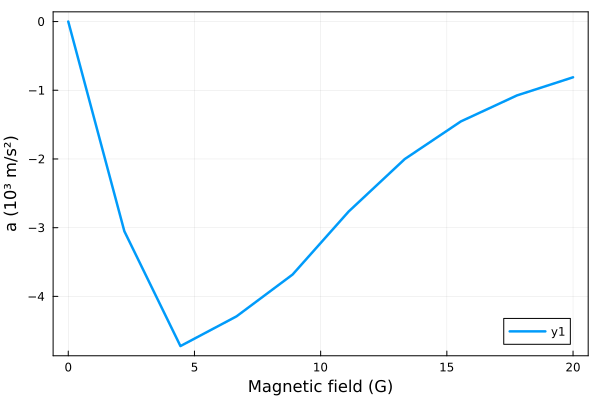

In [291]:
plot(Bs, 1e-3 .* averaged_forces .* (ħ * k * Γ / m),
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    # labelfontsize=14,
    # tickfont=12,
    # legendfont=11,
    # ylim=(-3,23),
    # size=(600,500)
    )

In [292]:
averaged_populations = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.B == B]
    push!(averaged_populations, mean([p for p in populations[idxs,:]], dims=1))
end

  0.183027 seconds (55.36 k allocations: 41.528 MiB, 57.74% compilation time)


In [293]:
averaged_populations[2]'

6×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.36172293391088645
 0.27271812168161585
 0.23792104499162098
 0.03987776017664217
 0.061932361745716306
 0.025827777493517803

In [23]:
d[:,:,1] |> print_matrix

Real part:
0 0 0 0 0 0 
0 0 0 0.71 0 0 
0 0 0 0 0.71 0 
0 0.71 0 0 0 0 
0 0 0.71 0 0 0 
0 0 0 0 0 0 

Imaginary part:
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 0 0 0 0 


In [24]:
Bs[4]

15.0

In [25]:
H.states[4]

State{AngularMomentumState_Labelled}(4.78e14, AngularMomentumState_Labelled[AngularMomentumState_Labelled(0.0, 0, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 0, 1, 1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, -1, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 0, (M = -1:1,)), AngularMomentumState_Labelled(0.0, 1, 1, 1, (M = -1:1,))], ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 4)

In [26]:
averaged_populations[4]'

6×1 adjoint(::Matrix{Float64}) with eltype Float64:
 0.06657220969459081
 0.5813993069728773
 0.3271908762272843
 0.0076846467657698736
 0.0045008786927672705
 0.012652081646711154

In [27]:
findmax([0,0,0,0,1,0,0,0])[2]

5

In [28]:
energy.(H.states)

6-element Vector{Float64}:
 0.0
 0.0
 0.0
 4.78e14
 4.78e14
 4.78e14

In [29]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Revise,
StaticArrays
;

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo

using Parameters

import ProgressMeter: Progress, next!



function N!(dN, N, rate_eq, τ)
    @unpack H,Hv, N0, N0_vec, ω, states, fields, r, v, Γ, λ, k, freq_res, d, R, v_prev, particle, extra_p= rate_eq
    if v_prev != v
        particle.v = v
        new_rate_eq = rate_equation(N0, particle, states, fields, d, d, true, true,λ, Γ, freq_res, extra_p)
        rate_eq.H = new_rate_eq.H
        rate_eq.Hv = new_rate_eq.Hv
        rate_eq.R = new_rate_eq.R
        rate_eq.v_prev = v
    end
    n_states = length(states)
    n_fields = length(fields)
    type_complex = ComplexF64
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)
    

    dN[:] .= 0.0
    
    # update dN

    dN[1:n_states] += H * N[1:n_states]

    
    # update integrated population
    dN[n_states+1 : end-3] = N[1:n_states]

    
    row_of_1 = StructArray(ones(type_complex, 1,n_states))

    # update force
    for p in 1:1:n_fields
    dN[end-2:end] += fields[p].k * (row_of_1 * Hv[:,:,p] * N[1:n_states])[1]
    end

    return nothing
end


function rate_equation(N0, particle, states, fields, d, d_m, should_round_freqs, alway_true, λ=1.0, Γ=2π, freq_res=1e-2, extra_p=nothing)

    period = 2π / freq_res

    n_states = length(states)
    n_fields = length(fields)

    states = StructArray(states)
    if n_fields > 0
        fields = StructArray(fields)
    end
    
    k = 2π / λ
    # particle.r0 *= 2π #(1 / k)  # `r` is in units of 1/k
    # particle.v /= (Γ / k) # velocity is in units of Γ/k
    # Convert to angular frequencies
    for i ∈ eachindex(fields)
        fields.ω[i] /= Γ
    end
    for i ∈ eachindex(states)
        states.E[i] *= 2π
        states.E[i] /= Γ
    end

    if should_round_freqs
        round_freqs!(states, fields, freq_res)
        particle.v = round_vel(particle.v, freq_res)
    end

    r0 = particle.r0
    r = particle.r
    v = particle.v
    v_prev = particle.v

    type_complex = ComplexF64


    ω = [state.E for state ∈ states]
    force_last_period = SVector(0.0, 0.0, 0.0)

    # matrix that updates populations:
    H = StructArray( zeros(type_complex, n_states, n_states) )
    n_l = extra_p.n_ground
    n_u = n_states - n_l
    n_fields = length(fields)

    # define R 
    R = StructArray(zeros(type_complex, n_l, n_u, n_fields))
    for p in 1:1:n_fields
        pol = fields[p].ϵ(0) #spherical
        # pol_cart = [(pol[1]-pol[3])/sqrt(2), (pol[1]+pol[3])/sqrt(2)*(-1im), pol[2]]
        for i in 1:1:n_l
            for j in 1:1:n_u
                ω_ij = energy(states[n_l + j]) - energy(states[i])
                ω_p = fields[p].ω
                doppler = 2π*fields[p].k ⋅ v
                f = -1 * pol[1]*d[i,n_l + j,3] + 1*pol[2]*d[i,n_l + j,2] - 1*pol[3]*d[i,n_l + j,1] 
                R[i,j,p] = 1/2 * real(f*conj(f)) * fields[p].s / (1 + 4*(ω_p - ω_ij - doppler)^2)
            end
        end
    end

    
    X = StructArray( zeros(type_complex, n_l, n_l, n_fields))
    for p in 1:1:n_fields
        for i in 1:1:n_l
            X[i,i,p] = sum(R[i,:,p])
        end
    end

    Y = StructArray(zeros(type_complex, n_u, n_u, n_fields))
    for p in 1:1:n_fields
        for j in 1:1:n_u
            Y[j,j,p] = sum(R[:,j,p])
        end
    end

    # define r (branching ratio of spontaneous decay)
    r = StructArray(zeros(type_complex, n_l, n_u))
    for i in 1:1:n_l 
        for j in 1:1:n_u 
            r[i,j] = norm(d[i,n_l + j,1])^2 + norm(d[i,n_l + j,2])^2 + norm(d[i,n_l + j,3])^2 
        end
    end

    # make sure population is conserved --- decay into lower = decay out from upper
    for j in 1:1:n_u
#         print( sum(r[:,j]))
        r[:,j] = r[:,j]./ sum(r[:,j])
    end

    id_l = Matrix((1.0+0im)LinearAlgebra.I, n_l, n_l)
    id_u = Matrix((1.0+0im)LinearAlgebra.I, n_u, n_u)

    H = StructArray(zeros(type_complex, n_states, n_states))
    for p in 1:1:n_fields
        H[1:n_l, 1:n_l] += -X[:,:,p]
        H[1:n_l, n_l+1:n_states] += R[:,:,p]
        H[n_l+1: n_states, 1:n_l] += transpose(R[:,:,p])
        H[n_l+1: n_states, n_l+1: n_states] += -Y[:,:,p]
    end

    
    H[1:n_l, n_l+1:n_states] += r[:,:]
    H[n_l+1:n_states, n_l+1:n_states] += -id_u

    # update matrix for force
    Hv = StructArray(zeros(type_complex, n_states, n_states, n_fields))
    for p in 1:1:n_fields
        Hv[1:n_l, n_l+1:n_states, p] = -R[:,:,p]
        Hv[n_l+1:end, 1:n_l, p] = transpose(R[:,:,p])
    end

    N0_vec=[N0; N0; 0;0;0]
    populations = N0[:];

    p = MutableNamedTuple(
        H=H, Hv=Hv, particle=particle, N0=N0, N0_vec=N0_vec, ω=ω,
        states=states, fields=fields, r0=r0, r=r, v=v, Γ=Γ, λ=λ,
        period=period, k=k, freq_res=freq_res,
        force_last_period=force_last_period, 
        d=d, 
        extra_p=extra_p, R=R, populations= populations, v_prev=v)

    return p
end
function round_freqs!(states, fields, freq_res)
    """
    Rounds frequencies of state energies and fields by a common denominator.
    
    freq_res::Float: all frequencies are rounded by this value (in units of Γ)
    """
    for i in eachindex(fields)
        fields.ω[i] = round_freq(fields.ω[i], freq_res)
    end
    for i in eachindex(states)
        states.E[i] = round_freq(states.E[i], freq_res)
    end
    return nothing
end


function reset_force1!(integrator)
    force_current_period = integrator.u[end-2:end] / integrator.p.period
    force_diff = abs(norm(force_current_period) - norm(integrator.p.force_last_period))
    force_diff_rel = force_diff / norm(integrator.p.force_last_period)
    integrator.p.force_last_period = force_current_period
    
    n = length(integrator.p.states)
    integrator.p.populations .= integrator.u[n+1:end-3] / integrator.p.period

    force_reltol = 1e-4
    if (force_diff_rel < force_reltol) #|| (force_diff < 1e-6)
        terminate!(integrator)
    else
        integrator.u[end-2:end] .= 0.0
        integrator.u[n+1:end-3] .= 0.0
    end
    return nothing
end


function force_scan_v3(prob::T1, scan_values::T2, prob_func!::F1, output_func::F2; n_threads=Threads.nthreads()) where {T1,T2,F1,F2}

    n_values = reduce(*, size(scan_values))
    batch_size = fld(n_values, n_threads)
    remainder = n_values - batch_size * n_threads
    forces = Array{SVector{3, Float64}}(undef, n_values)
    populations = zeros(Float64, n_values, length(prob.p.states))

    prog_bar = Progress(n_values)

    Threads.@threads for i ∈ 1:n_threads
        prob_copy = deepcopy(prob)
        # Threads.@spawn begin
            # prob_func!(_prob, scan_values, i)
        force_cb = PeriodicCallback(reset_force1!, prob_copy.p.period)
        if :callback ∈ keys(prob_copy.kwargs)
            cbs = prob_copy.kwargs[:callback]
            prob_copy = remake(prob_copy, callback=CallbackSet(cbs, force_cb))
        else
            prob_copy = remake(prob_copy, callback=force_cb)
        end
        _batch_size = i <= remainder ? (batch_size + 1) : batch_size
        batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)
        for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1)
            prob_j = prob_func!(prob_copy, scan_values, j)
            sol = solve(prob_j, alg=DP5())
            forces[j] = output_func(prob_j.p, sol)
            prob_j.p.force_last_period = (0, 0, 0)

            populations[j,:] .= prob_j.p.populations

            next!(prog_bar)
        end
    end
    return forces, populations
end;

# update the whole hamiltonian.
function remake_rate_equation_B(p, B)
    λ = p.λ
    Γ = p.Γ
 
    
 
    freq_res = p.freq_res
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    states = H.states
    lasers = p.extra_p.lasers
    
    new_p = rate_equation(p.N0, p.particle, states, p.extra_p.lasers, new_d, new_d, true, true, λ, Γ, freq_res, extra_p)
    return new_p
end;